# Energy Prediction
Energy prediction in short, medium, and long-term horizons is helpful in planning energy-efficient usage of the appliances, find anomalous usage patterns in buildings, and reliable and robust building-grid integration. While there exist multiple models for building energy prediction, we lack the tool to analyze and benchmark those models effectively. Subsequently, we end up reinventing the tool again and again. TransBEAM is a first step in the direction of developing reusable data-driven modeling techniques for building energy analytics and modeling. 

One must notice here that the reusable models are not just beneficial for benchmarking the techniques but also to make building energy analytics and modeling truely scalable. It is hard to gather data every time for every building at fine-granularity, and for those scenarios, an existing trained model could be a good starting point. That brings us to second major feature of TransBEAM: Knowledge Transferability! 

We would go into transferable aspect of TransBEAM in future notebooks and demonstrate data modeling with the help of a sample building using TransBEAM in this notebook. 

## Initial Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
import itertools
import pandas as pd 

import matplotlib.pyplot as plt
from transBEAM.utils import data_handler
from transBEAM.models import preprocessor, models

## Data Loading and Preprocessing

#### Step-1: Load the Data
TransBEAM can accept any type of time series data in the pandas DataFrame format. One can easily load the data using pandas DataFrame for next steps.

In [3]:
df = pd.read_csv('./sample_data/field_data.csv', usecols=['Date', 'Time', 'Temperature', 'Electricity'])
df['Date'] = df['Date'] + '-2020'
df

,Date,Time,Temperature,Electricity
0,01-01-2020,01:00,-2.0,205.28125
1,01-01-2020,02:00,-3.0,197.84375
2,01-01-2020,03:00,-3.0,210.50000
3,01-01-2020,04:00,-3.0,201.25000
4,01-01-2020,05:00,-3.0,209.87500
...,...,...,...,...
8755,12-31-2020,20:00,1.0,79.12500
8756,12-31-2020,21:00,1.0,85.75000
8757,12-31-2020,22:00,1.0,66.09375
8758,12-31-2020,23:00,0.5,76.03125


#### Step-2: Data Preprocessing
TimeSeriesDataHandler is a class to quickly and easily process the time series data. After data processing, the data can easily be accessed using the function `get_data()`

In [4]:
# process the data
building_dh = data_handler.TimeSeriesDataHandler()

b_name = 'isb1'
building_dh.add_data(df, b_name)
building_dh.add_datetime(b_name, dt_cols=['Date', 'Time'], dt_format='%m-%d-%Y %H:%M')
building_dh.add_static_features(b_name)
building_dh.add_shift_cols(b_name, col_names=["Temperature"], shift_by=[1])
building_dh.dropna(b_name)

In [5]:
df_processed = building_dh.get_data('isb1')
df_processed.head()

,Date,Time,Temperature,Electricity,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature
datetime,,,,,,,,,,
2020-01-01 02:00:00,01-01-2020,02:00,-3.0,197.84375,2,1,2,0,1,-2.0
2020-01-01 03:00:00,01-01-2020,03:00,-3.0,210.50000,2,1,3,0,1,-3.0
2020-01-01 04:00:00,01-01-2020,04:00,-3.0,201.25000,2,1,4,0,1,-3.0
2020-01-01 05:00:00,01-01-2020,05:00,-3.0,209.87500,2,1,5,0,1,-3.0
2020-01-01 06:00:00,01-01-2020,06:00,2.0,205.62500,2,1,6,0,1,-3.0


In [6]:
df_processed.columns

Index(['Date', 'Time', 'Temperature', 'Electricity', 'DayOfWeek', 'Weekday',
       'HourOfDay', 'WorkHour', 'Month', 'PrevTemperature'],
      dtype='object')

## Data Modeling
In this section, we will illustrate data modeling with the help of two already implemented models: Random Forest and Feed-Forward Neural Network. Before training the model, it is important that we seperate out features and the target model. In the current model, the library doesn't support sequential models.  

In [7]:
X_cols = ['Temperature', 'DayOfWeek', 'Weekday', 'HourOfDay', 'WorkHour', 'Month', 'PrevTemperature']
y_col = 'Electricity'

all_cols = X_cols + [y_col]

#### Step-3: Split and Normalize the Data

In [8]:
dp = preprocessor.DataPreprocessor()
train, test = dp.data_split(df_processed[all_cols], train_size=0.8)
train_norm = dp.normalize_data(train)

---------------- Size of Training Data:  0.8 % -------------------------
Size of Training Data:  (7004, 8)
Size of Testing Data:  (1752, 8)


### Model-1: Random Forest

#### Step-4: Train the Model

In [9]:
rf = models.RandomForest()
rf.train(train_norm[X_cols], train_norm[y_col])

#### Step-5: Predict on Test Set

In [10]:
test_norm = dp.normalize_data(test)
y_pred = rf.predict(test_norm[X_cols])

In [11]:
df_predictions = dp.inverse_transform(test_norm, y_pred, y_col)

#### Step-6: Visualize the Predictions

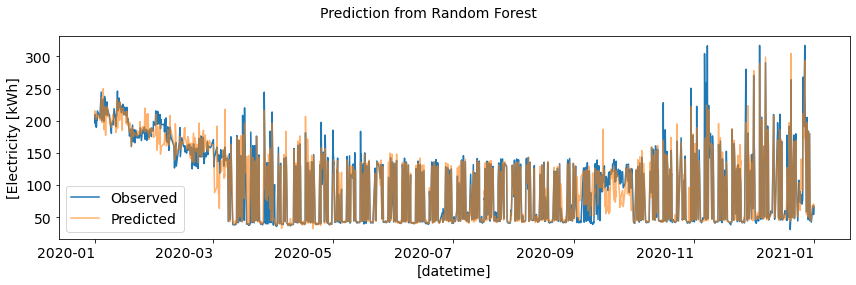

In [12]:
fontsize = 14
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

test["Electricity"].plot(ax=ax, label='Observed', fontsize=fontsize)
df_predictions["Electricity"].plot(ax=ax, alpha=0.6, label='Predicted', rot=0, fontsize=fontsize)

ax.set_xlabel("[datetime]", fontsize=fontsize)
ax.set_ylabel("[Electricity [kWh]", fontsize=fontsize)
ax.legend(fontsize=fontsize)

fig.suptitle('Prediction from Random Forest', fontsize=fontsize)
fig.tight_layout()

### Model-2: Feed Forward Network

#### Step-4: Train the Model

In [13]:
nn = models.FeedForwardNetwork(len(X_cols))
nn.train(train_norm[X_cols], train_norm[y_col])

Epoch 1/50
219/219 [==============================] - 2s 4ms/step - loss: 0.1385
Epoch 2/50
219/219 [==============================] - 1s 5ms/step - loss: 0.1006
Epoch 3/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0899
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0882
Epoch 5/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0817
Epoch 6/50
219/219 [==============================] - 1s 3ms/step - loss: 0.0776
Epoch 7/50
219/219 [==============================] - 1s 3ms/step - loss: 0.0714
Epoch 8/50
219/219 [==============================] - 1s 3ms/step - loss: 0.0672
Epoch 9/50
219/219 [==============================] - 1s 3ms/step - loss: 0.0648
Epoch 10/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0620
Epoch 11/50
219/219 [==============================] - 1s 4ms/step - loss: 0.0595
Epoch 12/50
219/219 [==============================] - 1s 5ms/step - loss: 0.0564
Epoch 13/50
219/219 [====

#### Step-5 Predict on Test Set

In [14]:
test_norm = dp.normalize_data(test)
y_pred = nn.predict(test_norm[X_cols])

In [15]:
df_predictions = dp.inverse_transform(test_norm, y_pred, y_col)
df_predictions

,Temperature,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature,Electricity
datetime,,,,,,,,
2020-05-14 23:00:00,13.8,3.0,1.0,23.0,0.0,5.0,13.8,42.405730
2020-03-03 03:00:00,-1.6,1.0,1.0,3.0,0.0,3.0,1.3,76.089594
2020-11-02 05:00:00,9.0,0.0,1.0,5.0,0.0,11.0,10.0,159.886462
2020-09-13 00:00:00,11.0,6.0,0.0,0.0,0.0,9.0,12.0,43.423329
2020-01-18 22:00:00,-3.0,5.0,0.0,22.0,0.0,1.0,-4.0,177.818300
...,...,...,...,...,...,...,...,...
2020-10-23 17:00:00,10.0,4.0,1.0,17.0,1.0,10.0,10.5,80.663406
2020-07-04 23:00:00,17.0,5.0,0.0,23.0,0.0,7.0,18.0,44.417774
2020-09-03 09:00:00,16.0,3.0,1.0,9.0,1.0,9.0,13.0,42.319885


#### Step-6: Visualize the Predictions

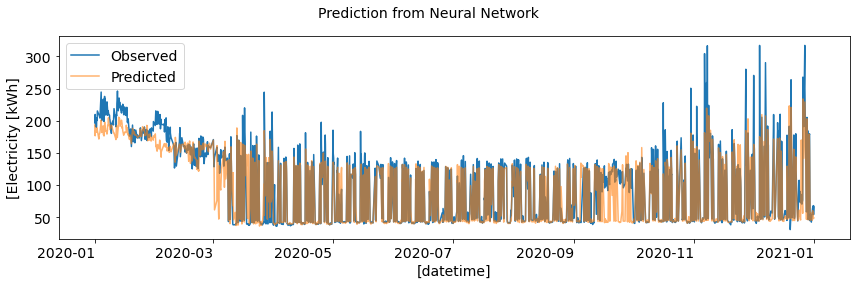

In [16]:
fontsize = 14
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

test["Electricity"].plot(ax=ax, label='Observed', fontsize=fontsize)
df_predictions["Electricity"].plot(ax=ax, alpha=0.6, label='Predicted', rot=0, fontsize=fontsize)

ax.set_xlabel("[datetime]", fontsize=fontsize)
ax.set_ylabel("[Electricity [kWh]", fontsize=fontsize)
ax.legend(fontsize=fontsize)

fig.suptitle('Prediction from Neural Network', fontsize=fontsize)
fig.tight_layout()